In [ ]:
pip install git+https://github.com/IDEA-Research/GroundingDINO.git

In [8]:
# Установи: pip install groundingdino-py
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from groundingdino.util.inference import load_model, load_image, predict

def simple_grounding_dino(image_path, text_prompt):
    """Простой GroundingDINO - только детекция по тексту"""
    
    print(f"🔍 Ищем: '{text_prompt}'")
    
    # 1. Загружаем модель (автоскачается при первом запуске)
    print("📥 Загружаем GroundingDINO...")
    model = load_model(
        "/home/oleg/projects/ML/DINO_Grounding/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py", 
        #"weights/groundingdino_swint_ogc.pth"
    )
    
    # 2. Загружаем изображение
    image_source, image = load_image(image_path)
    
    # 3. Ищем объекты по тексту
    print("🎯 Ищем объекты...")
    boxes, scores, phrases = predict(
        model=model,
        image=image, 
        caption=text_prompt,
        box_threshold=0.35,    # Минимальная уверенность bbox
        text_threshold=0.25    # Минимальное соответствие тексту
    )
    
    # 4. Показываем что нашли
    print(f"✅ Найдено объектов: {len(boxes)}")
    for i, (phrase, score) in enumerate(zip(phrases, scores)):
        print(f"   {i+1}. {phrase} (уверенность: {score:.3f})")
    
    # 5. Рисуем результат
    image_display = image_source[0].permute(1, 2, 0).cpu().numpy()
    
    plt.figure(figsize=(12, 8))
    plt.imshow(image_display)
    
    # Рисуем bounding boxes
    for i, (box, phrase, score) in enumerate(zip(boxes, phrases, scores)):
        # Конвертируем координаты
        H, W = image_source.shape[1], image_source.shape[2]
        x1, y1, x2, y2 = box * torch.tensor([W, H, W, H])
        
        # Рисуем прямоугольник
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, 
                           linewidth=3, edgecolor='red', facecolor='none')
        plt.gca().add_patch(rect)
        
        # Добавляем подпись
        label = f"{phrase} ({score:.2f})"
        plt.text(x1, y1-10, label, 
                fontsize=12, fontweight='bold', color='white',
                bbox=dict(boxstyle="round,pad=0.3", facecolor='red', alpha=0.8))
    
    plt.axis('off')
    plt.title(f"GroundingDINO: '{text_prompt}'\nНайдено: {len(boxes)} объектов", fontsize=14)
    plt.tight_layout()
    plt.show()

# 🎯 ПРОСТЫЕ ПРИМЕРЫ:

print("=== ПРИМЕР 1: Человек ===")
simple_grounding_dino(
    "/home/oleg/projects/ML/CLIP/images/0d354ad89e92986b19b10a8ac2797dfb.jpg",
    "person"
)

print("\n=== ПРИМЕР 2: Несколько объектов ===")
simple_grounding_dino(
    "/home/oleg/projects/ML/CLIP/images/0d354ad89e92986b19b10a8ac2797dfb.jpg", 
    "person . laptop . cup"
)

print("\n=== ПРИМЕР 3: Только чашка ===")
simple_grounding_dino(
    "/home/oleg/projects/ML/CLIP/images/0d354ad89e92986b19b10a8ac2797dfb.jpg",
    "cup"
)

=== ПРИМЕР 1: Человек ===
🔍 Ищем: 'person'
📥 Загружаем GroundingDINO...


TypeError: load_model() missing 1 required positional argument: 'model_checkpoint_path'

In [12]:
import supervision as sv
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# --- ВХОДНЫЕ ДАННЫЕ ---
IMAGE_PATH = "/home/oleg/projects/ML/CLIP/images/0d354ad89e92986b19b10a8ac2797dfb.jpg"
TEXT_PROMPT = "person . laptop . cup"
BOX_THRESHOLD = 0.35
TEXT_THRESHOLD = 0.25

def simple_grounding_dino_sv(image_path, text_prompt):
    print(f"🔍 Ищем: '{text_prompt}' через SuperVision")
    
    # 1. Загрузка модели (SuperVision автоматически скачает веса и конфиг)
    print("📥 Загружаем GroundingDINO (Swin-T OGC)...")
    # Используем GroundingDINOModel, который является оберткой
    model = sv.GroundingDINO(model_id="groundingdino_swin-t_ogc")

    # 2. Загрузка изображения (как PIL Image)
    image_pil = Image.open(image_path).convert("RGB")
    image_np = np.array(image_pil) # Переводим в NumPy для SuperVision

    # 3. Ищем объекты по тексту
    print("🎯 Ищем объекты...")
    detections = model.predict(
        image=image_pil, 
        caption=text_prompt, 
        box_threshold=BOX_THRESHOLD, 
        text_threshold=TEXT_THRESHOLD
    )
    
    # 4. Показываем что нашли
    print(f"✅ Найдено объектов: {len(detections)}")
    
    # SuperVision хранит метки (phrases) в атрибуте data['class_name']
    if 'class_name' in detections.data:
        for i, (box, class_name) in enumerate(zip(detections.xyxy, detections.data['class_name'])):
            # Score (уверенность) хранится в detections.confidence
            score = detections.confidence[i] if detections.confidence is not None else 0.0
            print(f"   {i+1}. {class_name} (уверенность: {score:.3f})")

    # 5. Рисуем результат
    # Аннотаторы SuperVision упрощают отрисовку
    box_annotator = sv.BoxAnnotator(
        thickness=3, 
        text_thickness=2, 
        text_scale=1
    )
    
    annotated_image = box_annotator.annotate(
        scene=image_np.copy(), 
        detections=detections,
        # Форматирование подписей
        labels=[
            f"{class_name} ({confidence:.2f})"
            for class_name, confidence in zip(detections.data['class_name'], detections.confidence)
        ]
    )
    
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"GroundingDINO (via SuperVision): '{text_prompt}'\nНайдено: {len(detections)} объектов", fontsize=14)
    plt.tight_layout()
    plt.show()

# 🎯 Запуск примера:
simple_grounding_dino_sv(
    IMAGE_PATH,
    TEXT_PROMPT
)

🔍 Ищем: 'person . laptop . cup' через SuperVision
📥 Загружаем GroundingDINO (Swin-T OGC)...


AttributeError: module 'supervision' has no attribute 'GroundingDINO'

In [10]:
from transformers import pipeline
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- ВХОДНЫЕ ДАННЫЕ ---
IMAGE_PATH = "/home/oleg/projects/ML/CLIP/images/0d354ad89e92986b19b10a8ac2797dfb.jpg"
TEXT_PROMPT = "person . laptop . cup"
BOX_THRESHOLD = 0.35 # Обратите внимание: в pipeline пороги часто фиксированы или задаются через arguments

def simple_grounding_dino_hf(image_path, text_prompt):
    print(f"🔍 Ищем: '{text_prompt}' через Hugging Face Pipeline")

    # 1. Загрузка модели через pipeline
    # Используется Grounding DINO (Swin-B), так как это стандарт для HF
    print("📥 Загружаем GroundingDINO (Swin-B)...")
    detector = pipeline(
        "zero-shot-object-detection", 
        model="IDEA-Research/grounding-dino-base", # Используем модель Base
        device=0 if torch.cuda.is_available() else -1 # Устанавливаем GPU или CPU
    )

    # 2. Загрузка изображения
    image_np = cv2.imread(image_path)
    image_np = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)

    # 3. Ищем объекты по тексту
    # HF Pipeline принимает список меток, а не одну строку с точками
    labels = [label.strip() for label in text_prompt.split('.') if label.strip()]
    print(f"🎯 Ищем метки: {labels}")
    
    # Результат содержит bounding box, метку и score
    results = detector(image_np, candidate_labels=labels) 

    # 4. Показываем что нашли
    print(f"✅ Найдено объектов: {len(results)}")
    
    # 5. Рисуем результат
    plt.figure(figsize=(12, 8))
    plt.imshow(image_np)
    
    for i, result in enumerate(results):
        box = result['box']
        label = result['label']
        score = result['score']
        
        # Конвертируем координаты
        x1, y1, x2, y2 = box['xmin'], box['ymin'], box['xmax'], box['ymax']

        print(f"   {i+1}. {label} (уверенность: {score:.3f})")
        
        # Рисуем прямоугольник
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, 
                            linewidth=3, edgecolor='green', facecolor='none')
        plt.gca().add_patch(rect)
        
        # Добавляем подпись
        label_text = f"{label} ({score:.2f})"
        plt.text(x1, y1 - 10, label_text, 
                 fontsize=12, fontweight='bold', color='white',
                 bbox=dict(boxstyle="round,pad=0.3", facecolor='green', alpha=0.8))

    plt.axis('off')
    plt.title(f"GroundingDINO (via HF Transformers): '{text_prompt}'\nНайдено: {len(results)} объектов", fontsize=14)
    plt.tight_layout()
    plt.show()

# 🎯 Запуск примера:
simple_grounding_dino_hf(
    IMAGE_PATH,
    TEXT_PROMPT
)

🔍 Ищем: 'person . laptop . cup' через Hugging Face Pipeline
📥 Загружаем GroundingDINO (Swin-B)...


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/933M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/457 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cuda:0


🎯 Ищем метки: ['person', 'laptop', 'cup']


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [14]:
# Если вы еще не устанавливали transformers и accelerate
# pip install transformers accelerate

# Затем запустите этот код:
from transformers import pipeline
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- ВХОДНЫЕ ДАННЫЕ ---
IMAGE_PATH = "/home/oleg/projects/ML/CLIP/images/0d354ad89e92986b19b10a8ac2797dfb.jpg"
TEXT_PROMPT = "person . laptop . cup"

def simple_grounding_dino_hf(image_path, text_prompt):
    print(f"🔍 Ищем: '{text_prompt}' через Hugging Face Pipeline")
    
    # 1. Загрузка модели через pipeline
    print("📥 Загружаем GroundingDINO (Swin-B)...")
    # Используем модель Base от HF (она надежно работает)
    detector = pipeline(
        "zero-shot-object-detection", 
        model="IDEA-Research/grounding-dino-base",
        # device=0 или 'cuda:0' для GPU, -1 для CPU
        device=-1 # Явно укажем CPU, чтобы избежать проблем с CUDA
    )

    # 2. Загрузка изображения
    image_np = cv2.imread(image_path)
    image_np = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)

    # 3. Ищем объекты по тексту
    labels = [label.strip() for label in text_prompt.split('.') if label.strip()]
    print(f"🎯 Ищем метки: {labels}")
    
    results = detector(image_np, candidate_labels=labels) 

    # 4. Показываем что нашли (вывод только текста)
    print(f"✅ Найдено объектов: {len(results)}")
    for i, result in enumerate(results):
        print(f"   {i+1}. {result['label']} (уверенность: {result['score']:.3f})")

    # 5. Рисуем результат (код отрисовки)
    plt.figure(figsize=(12, 8))
    plt.imshow(image_np)
    # ... (код отрисовки прямоугольников, как в предыдущем ответе)
    plt.axis('off')
    plt.title(f"GroundingDINO (via HF Transformers): '{text_prompt}'\nНайдено: {len(results)} объектов", fontsize=14)
    plt.tight_layout()
    plt.show()

# 🎯 Запуск примера:
simple_grounding_dino_hf(
    IMAGE_PATH,
    TEXT_PROMPT
)

🔍 Ищем: 'person . laptop . cup' через Hugging Face Pipeline
📥 Загружаем GroundingDINO (Swin-B)...


Device set to use cpu


🎯 Ищем метки: ['person', 'laptop', 'cup']


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [15]:
from transformers import pipeline
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch # Добавьте torch для проверки наличия CUDA

# --- ВХОДНЫЕ ДАННЫЕ ---
IMAGE_PATH = "/home/oleg/projects/ML/CLIP/images/0d354ad89e92986b19b10a8ac2797dfb.jpg"
TEXT_PROMPT = "person . laptop . cup"

def simple_grounding_dino_hf(image_path, text_prompt):
    print(f"🔍 Ищем: '{text_prompt}' через Hugging Face Pipeline")
    
    # 1. Загрузка модели через pipeline
    print("📥 Загружаем GroundingDINO (Swin-B)...")
    detector = pipeline(
        "zero-shot-object-detection", 
        model="IDEA-Research/grounding-dino-base",
        # device=0 или 'cuda:0' для GPU, -1 для CPU
        device=0 if torch.cuda.is_available() else -1 
    )

    # 2. Загрузка изображения
    image_np = cv2.imread(image_path)
    image_np = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)

    # 3. Ищем объекты по тексту
    labels = [label.strip() for label in text_prompt.split('.') if label.strip()]
    print(f"🎯 Ищем метки: {labels}")
    
    # ИСПРАВЛЕНИЕ ЗДЕСЬ: Передаем словарь вместо позиционных аргументов
    inputs = {"image": image_np, "candidate_labels": labels}
    results = detector(inputs)
    
    # 4. Показываем что нашли
    print(f"✅ Найдено объектов: {len(results)}")
    
    # 5. Рисуем результат
    # ... (Остальная часть кода отрисовки)
    plt.figure(figsize=(12, 8))
    plt.imshow(image_np)
    
    for i, result in enumerate(results):
        box = result['box']
        label = result['label']
        score = result['score']
        
        # Конвертируем координаты
        x1, y1, x2, y2 = box['xmin'], box['ymin'], box['xmax'], box['ymax']

        print(f"   {i+1}. {label} (уверенность: {score:.3f})")
        
        # Рисуем прямоугольник
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, 
                            linewidth=3, edgecolor='green', facecolor='none')
        plt.gca().add_patch(rect)
        
        # Добавляем подпись
        label_text = f"{label} ({score:.2f})"
        plt.text(x1, y1 - 10, label_text, 
                 fontsize=12, fontweight='bold', color='white',
                 bbox=dict(boxstyle="round,pad=0.3", facecolor='green', alpha=0.8))

    plt.axis('off')
    plt.title(f"GroundingDINO (via HF Transformers): '{text_prompt}'\nНайдено: {len(results)} объектов", fontsize=14)
    plt.tight_layout()
    plt.show()

# 🎯 Запуск примера:
simple_grounding_dino_hf(
    IMAGE_PATH,
    TEXT_PROMPT
)

🔍 Ищем: 'person . laptop . cup' через Hugging Face Pipeline
📥 Загружаем GroundingDINO (Swin-B)...


Device set to use cuda:0


🎯 Ищем метки: ['person', 'laptop', 'cup']


TypeError: Incorrect format used for image. Should be an url linking to an image, a base64 string, a local path, or a PIL image.

🔍 Ищем: 'person . laptop . cup' через Hugging Face Pipeline
📥 Загружаем GroundingDINO (Swin-B)...


Device set to use cuda:0


🎯 Ищем метки: ['person', 'laptop', 'cup']
✅ Найдено объектов: 29
   1. laptop (уверенность: 0.265)
   2. cup (уверенность: 0.238)
   3. laptop (уверенность: 0.207)
   4. laptop (уверенность: 0.204)
   5. person (уверенность: 0.195)
   6. person (уверенность: 0.195)
   7. laptop (уверенность: 0.195)
   8. cup (уверенность: 0.191)
   9. cup (уверенность: 0.187)
   10. person (уверенность: 0.184)
   11. laptop (уверенность: 0.177)
   12. cup (уверенность: 0.169)
   13. cup (уверенность: 0.165)
   14. laptop (уверенность: 0.152)
   15. person (уверенность: 0.149)
   16. person (уверенность: 0.146)
   17. laptop (уверенность: 0.144)
   18. laptop (уверенность: 0.141)
   19. person (уверенность: 0.140)
   20. cup (уверенность: 0.132)
   21. person (уверенность: 0.131)
   22. person (уверенность: 0.130)
   23. laptop (уверенность: 0.128)
   24. laptop (уверенность: 0.128)
   25. laptop (уверенность: 0.127)
   26. laptop (уверенность: 0.123)
   27. laptop (уверенность: 0.122)
   28. laptop (ув

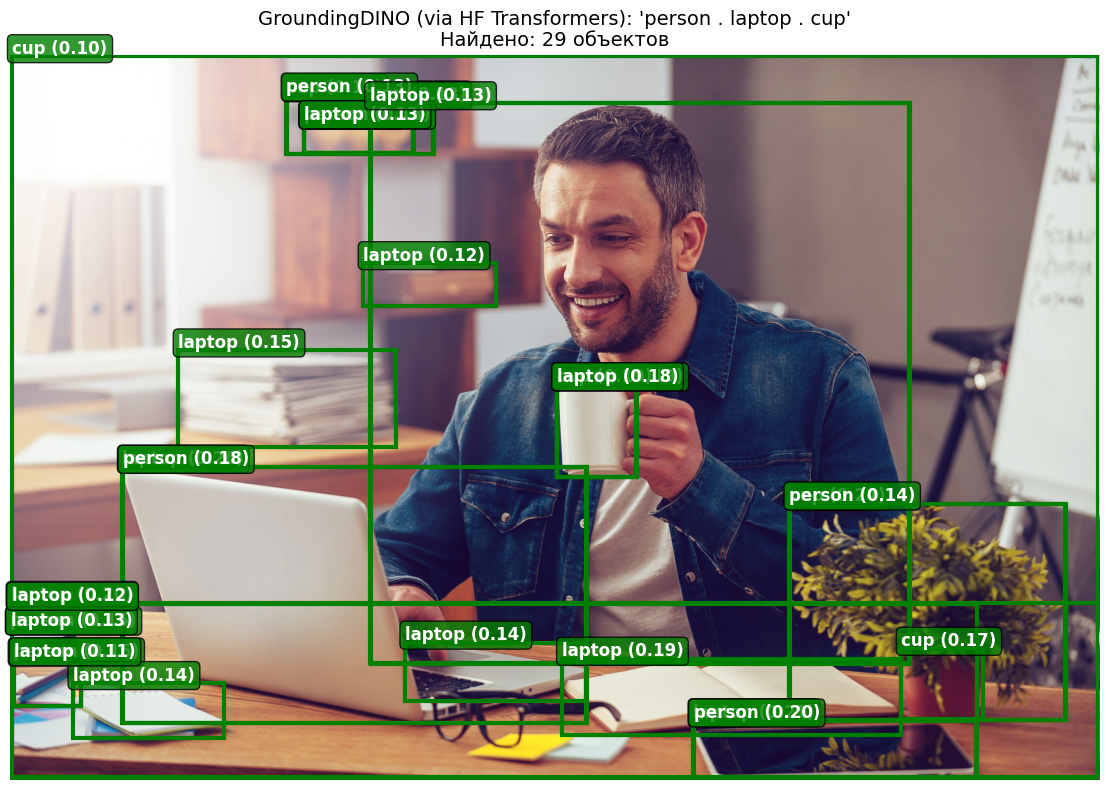

In [16]:
from transformers import pipeline
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from PIL import Image # <-- Добавляем импорт PIL

# --- ВХОДНЫЕ ДАННЫЕ ---
IMAGE_PATH = "/home/oleg/projects/ML/CLIP/images/0d354ad89e92986b19b10a8ac2797dfb.jpg"
TEXT_PROMPT = "person . laptop . cup"

def simple_grounding_dino_hf(image_path, text_prompt):
    print(f"🔍 Ищем: '{text_prompt}' через Hugging Face Pipeline")

    # 1. Загрузка модели через pipeline
    print("📥 Загружаем GroundingDINO (Swin-B)...")
    detector = pipeline(
        "zero-shot-object-detection", 
        model="IDEA-Research/grounding-dino-base",
        device=0 if torch.cuda.is_available() else -1 
    )

    # 2. Загрузка изображения ИСПРАВЛЕНА
    image_pil = Image.open(image_path).convert("RGB") # <-- Загрузка через PIL
    image_np = np.array(image_pil) # <-- Для отрисовки
    
    # 3. Ищем объекты по тексту
    labels = [label.strip() for label in text_prompt.split('.') if label.strip()]
    print(f"🎯 Ищем метки: {labels}")
    
    # ПЕРЕДАЧА ВЫХОДИТ ИЗ PIL-ОБЪЕКТА
    inputs = {"image": image_pil, "candidate_labels": labels} 
    results = detector(inputs) # <-- Теперь должно сработать
    
    # 4. Показываем что нашли
    print(f"✅ Найдено объектов: {len(results)}")
    
    # 5. Рисуем результат
    plt.figure(figsize=(12, 8))
    plt.imshow(image_np)
    
    for i, result in enumerate(results):
        box = result['box']
        label = result['label']
        score = result['score']
        
        # Конвертируем координаты
        x1, y1, x2, y2 = box['xmin'], box['ymin'], box['xmax'], box['ymax']

        print(f"   {i+1}. {label} (уверенность: {score:.3f})")
        
        # Рисуем прямоугольник
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, 
                            linewidth=3, edgecolor='green', facecolor='none')
        plt.gca().add_patch(rect)
        
        # Добавляем подпись
        label_text = f"{label} ({score:.2f})"
        plt.text(x1, y1 - 10, label_text, 
                 fontsize=12, fontweight='bold', color='white',
                 bbox=dict(boxstyle="round,pad=0.3", facecolor='green', alpha=0.8))

    plt.axis('off')
    plt.title(f"GroundingDINO (via HF Transformers): '{text_prompt}'\nНайдено: {len(results)} объектов", fontsize=14)
    plt.tight_layout()
    plt.show()

# 🎯 Запуск примера:
simple_grounding_dino_hf(
    IMAGE_PATH,
    TEXT_PROMPT
)


In [24]:
# Уже входит в huggingface_hub
from huggingface_hub import notebook_login

# Логин в интерфейсе Jupyter
notebook_login()

In [ ]:
# Download the model
hf download openmmlab-community/mm_grounding_dino_large_all

In [32]:
from transformers import pipeline

# Укажите путь, куда вы хотите сохранить модель
LOCAL_MODEL_PATH = "/home/oleg/projects/ML/DINO_Grounding/GroundingDINO/mm_grounding_dino_large_all" 

# 1. Загружаем модель (она скачается с хаба)
temp_detector = pipeline(
    "zero-shot-object-detection", 
    model="IDEA-Research/grounding-dino-large"
)

# 2. Сохраняем модель в локальный репозиторий
temp_detector.save_pretrained(LOCAL_MODEL_PATH)

print(f"✅ Модель Grounding DINO Large сохранена локально по пути: {LOCAL_MODEL_PATH}")

OSError: IDEA-Research/grounding-dino-large is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `hf auth login` or by passing `token=<your_token>`

In [33]:
from transformers import pipeline
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from PIL import Image 

# --- ВХОДНЫЕ ДАННЫЕ ---
IMAGE_PATH = "/home/oleg/projects/ML/CLIP/images/0d354ad89e92986b19b10a8ac2797dfb.jpg"
TEXT_PROMPT = "a person holding a cup"
#TEXT_PROMPT = "person . laptop . cup"

# ✅ ЯВНО ЗАДАЕМ ПОРОГ ТОЧНОСТИ ЗДЕСЬ
DETECTION_THRESHOLD = 0.1 

def simple_grounding_dino_hf(image_path, text_prompt):
    print(f"🔍 Ищем: '{text_prompt}' через Hugging Face Pipeline (Порог: {DETECTION_THRESHOLD})")

    # 1. Загрузка модели через pipeline
    print("📥 Загружаем GroundingDINO (Swin-B)...")
    detector = pipeline(
        "zero-shot-object-detection", 
        #model="IDEA-Research/grounding-dino-base",
        model="/home/oleg/projects/ML/DINO_Grounding/GroundingDINO/mm_grounding_dino_large_all", # <-- ИСПОЛЬЗУЕМ ВЕРСИЮ LARGE
        # model="IDEA-Research/grounding-dino-large", # <-- ИСПОЛЬЗУЕМ ВЕРСИЮ LARGE
        device=0 if torch.cuda.is_available() else -1 
    )

    # 2. Загрузка изображения
    image_pil = Image.open(image_path).convert("RGB")
    image_np = np.array(image_pil)
    
    # 3. Ищем объекты по тексту
    labels = [label.strip() for label in text_prompt.split('.') if label.strip()]
    print(f"🎯 Ищем метки: {labels}")
    
    # ПЕРЕДАЧА ВЫХОДИТ ИЗ PIL-ОБЪЕКТА
    inputs = {"image": image_pil, "candidate_labels": labels} 
    
    # ✅ ИСПРАВЛЕНИЕ: Передача порога в вызов детектора
    results = detector(
        inputs, 
        threshold=DETECTION_THRESHOLD 
    ) 
    
    # 4. Показываем что нашли
    print(f"✅ Найдено объектов: {len(results)}")
    
    # 5. Рисуем результат
    # ... (код отрисовки)
    plt.figure(figsize=(12, 8))
    plt.imshow(image_np)
    
    for i, result in enumerate(results):
        box = result['box']
        label = result['label']
        score = result['score']
        
        # Конвертируем координаты
        x1, y1, x2, y2 = box['xmin'], box['ymin'], box['xmax'], box['ymax']

        print(f"   {i+1}. {label} (уверенность: {score:.3f})")
        
        # Рисуем прямоугольник
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, 
                            linewidth=3, edgecolor='green', facecolor='none')
        plt.gca().add_patch(rect)
        
        # Добавляем подпись
        label_text = f"{label} ({score:.2f})"
        plt.text(x1, y1 - 10, label_text, 
                 fontsize=12, fontweight='bold', color='white',
                 bbox=dict(boxstyle="round,pad=0.3", facecolor='green', alpha=0.8))

    plt.axis('off')
    plt.title(f"GroundingDINO (via HF Transformers): '{text_prompt}'\nНайдено: {len(results)} объектов", fontsize=14)
    plt.tight_layout()
    plt.show()

# 🎯 Запуск примера:
simple_grounding_dino_hf(
    IMAGE_PATH,
    TEXT_PROMPT
)

SyntaxError: invalid syntax. Perhaps you forgot a comma? (727310948.py, line 23)

In [28]:
import torch
import os
import sys
from PIL import Image
import matplotlib.pyplot as plt

# Добавляем путь к GroundingDINO
sys.path.append("/home/oleg/projects/ML/DINO_Grounding/GroundingDINO")

def use_grounding_dino_local_correct(image_path, text_prompt):
    """Правильное использование локальной модели GroundingDINO"""
    
    try:
        # Импортируем из ЛОКАЛЬНОЙ установки
        from groundingdino.util.inference import load_model, load_image, predict
        
        # 1. Пути к конфигу и весам
        config_path = "/home/oleg/projects/ML/DINO_Grounding/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py"
        weights_path = "/home/oleg/projects/ML/DINO_Grounding/GroundingDINO/weights/groundingdino_swint_ogc.pth"
        
        # Проверяем наличие весов
        if not os.path.exists(weights_path):
            print("❌ Веса не найдены! Скачиваем...")
            download_weights(weights_path)
        
        print("📥 Загружаем локальную модель...")
        model = load_model(config_path, weights_path)
        
        # 2. Загружаем изображение
        image_source, image = load_image(image_path)
        
        # 3. Детекция
        boxes, scores, phrases = predict(
            model=model,
            image=image,
            caption=text_prompt,
            box_threshold=0.35,
            text_threshold=0.25
        )
        
        # 4. Результаты
        print(f"✅ Найдено: {len(boxes)} объектов")
        for i, (phrase, score) in enumerate(zip(phrases, scores)):
            print(f"   {i+1}. {phrase} ({score:.3f})")
        
        # 5. Визуализация
        visualize_results(image_source, boxes, phrases, scores, text_prompt)
        
    except Exception as e:
        print(f"❌ Ошибка: {e}")

def download_weights(weights_path):
    """Скачивание весов"""
    import urllib.request
    os.makedirs(os.path.dirname(weights_path), exist_ok=True)
    
    url = "https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth"
    
    try:
        print("📥 Скачиваем веса...")
        urllib.request.urlretrieve(url, weights_path)
        print("✅ Веса скачаны!")
    except Exception as e:
        print(f"❌ Ошибка скачивания: {e}")

def visualize_results(image_source, boxes, phrases, scores, text_prompt):
    """Визуализация"""
    image_display = image_source[0].permute(1, 2, 0).cpu().numpy()
    
    plt.figure(figsize=(12, 8))
    plt.imshow(image_display)
    
    for i, (box, phrase, score) in enumerate(zip(boxes, phrases, scores)):
        H, W = image_source.shape[1], image_source.shape[2]
        x1, y1, x2, y2 = box * torch.tensor([W, H, W, H])
        
        # Bounding box
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, 
                           linewidth=3, edgecolor='red', facecolor='none')
        plt.gca().add_patch(rect)
        
        # Label
        label = f"{phrase} ({score:.2f})"
        plt.text(x1, y1-10, label, 
                fontsize=12, fontweight='bold', color='white',
                bbox=dict(boxstyle="round,pad=0.3", facecolor='red', alpha=0.8))
    
    plt.axis('off')
    plt.title(f"GroundingDINO Local: '{text_prompt}'\nНайдено: {len(boxes)} объектов")
    plt.tight_layout()
    plt.show()

# 🚀 ЗАПУСК
IMAGE_PATH = "/home/oleg/projects/ML/CLIP/images/0d354ad89e92986b19b10a8ac2797dfb.jpg"
TEXT_PROMPT = "person . laptop . cup"

use_grounding_dino_local_correct(IMAGE_PATH, TEXT_PROMPT)

❌ Веса не найдены! Скачиваем...
📥 Скачиваем веса...
✅ Веса скачаны!
📥 Загружаем локальную модель...


/home/oleg/miniconda3/envs/tensflow/lib/python3.11/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


/home/oleg/miniconda3/envs/tensflow/lib/python3.11/site-packages/groundingdino/util/inference.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(mo

✅ Найдено: 3 объектов
   1. person (0.907)
   2. laptop (0.861)
   3. cup (0.825)
❌ Ошибка: 'numpy.ndarray' object has no attribute 'permute'


/home/oleg/miniconda3/envs/tensflow/lib/python3.11/site-packages/groundingdino/models/GroundingDINO/transformer.py:862: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


In [34]:
from transformers import pipeline
from PIL import Image
import matplotlib.pyplot as plt

def use_grounding_dino_hf_simple(image_path, text_prompt):
    """Использование GroundingDINO через Hugging Face"""
    
    print("📥 Загружаем модель из Hugging Face...")
    
    try:
        # Используем ОФИЦИАЛЬНУЮ модель из HF Hub
        detector = pipeline(
            "zero-shot-object-detection", 
            model="IDEA-Research/grounding-dino-large",  # Автоскачается
            device=0 if torch.cuda.is_available() else -1
        )
        
        image = Image.open(image_path).convert("RGB")
        objects = [obj.strip() for obj in text_prompt.split('.') if obj.strip()]
        
        all_results = []
        for obj in objects:
            results = detector(image, candidate_labels=[obj])
            all_results.extend(results)
        
        # Визуализация
        plt.figure(figsize=(12, 8))
        plt.imshow(image)
        
        print(f"✅ Найдено: {len(all_results)} объектов")
        for i, result in enumerate(all_results):
            box = result['box']
            label = result['label']
            score = result['score']
            
            print(f"   {i+1}. {label} ({score:.3f})")
            
            rect = plt.Rectangle(
                (box['xmin'], box['ymin']), 
                box['xmax']-box['xmin'], 
                box['ymax']-box['ymin'],
                linewidth=3, edgecolor='red', facecolor='none'
            )
            plt.gca().add_patch(rect)
            
            plt.text(box['xmin'], box['ymin']-10, f"{label} ({score:.2f})",
                    fontsize=12, fontweight='bold', color='white',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor='red', alpha=0.8))
        
        plt.axis('off')
        plt.title(f"GroundingDINO: '{text_prompt}'\nНайдено: {len(all_results)} объектов")
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"❌ Ошибка: {e}")

# Запуск
use_grounding_dino_hf_simple(IMAGE_PATH, TEXT_PROMPT)

📥 Загружаем модель из Hugging Face...
❌ Ошибка: IDEA-Research/grounding-dino-large is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `hf auth login` or by passing `token=<your_token>`


📥 Загружаем локальную модель...
final text_encoder_type: bert-base-uncased
✅ Найдено: 3 объектов
   1. person (0.907)
   2. laptop (0.861)
   3. cup (0.825)


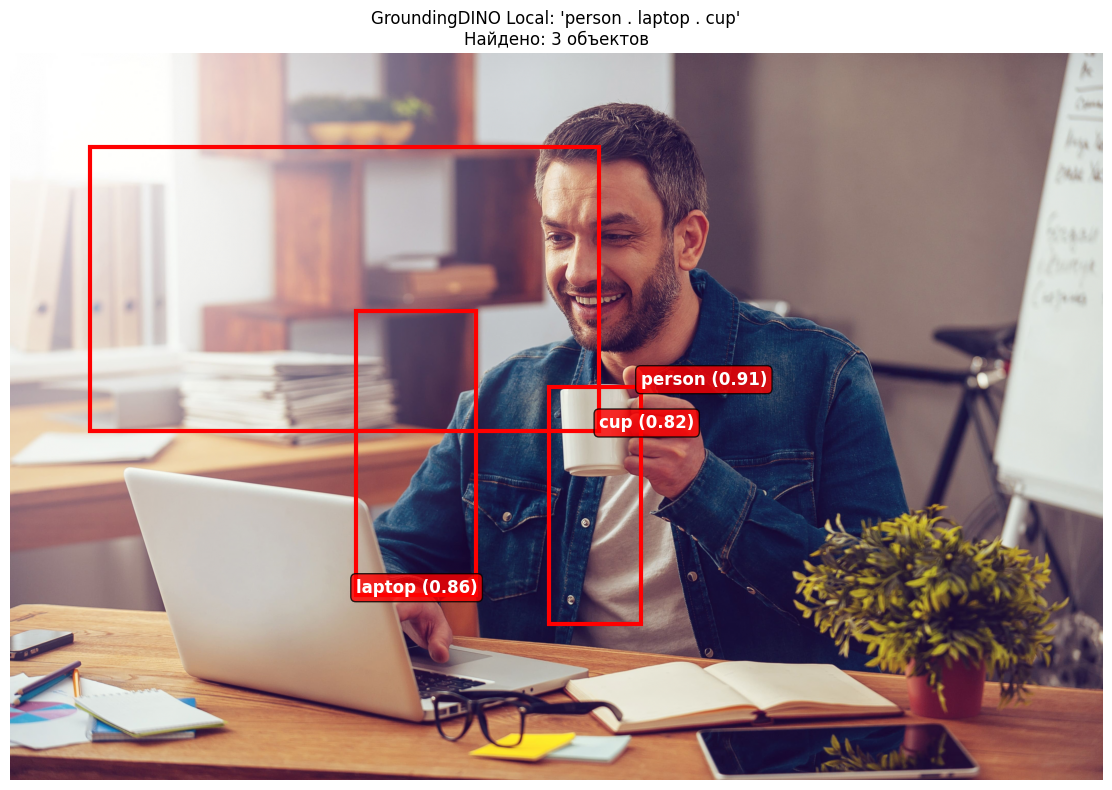

In [30]:
import torch
import os
import sys
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Добавляем путь к GroundingDINO
sys.path.append("/home/oleg/projects/ML/DINO_Grounding/GroundingDINO")

def use_grounding_dino_local_correct(image_path, text_prompt):
    """Правильное использование локальной модели GroundingDINO"""
    
    try:
        # Импортируем из ЛОКАЛЬНОЙ установки
        from groundingdino.util.inference import load_model, load_image, predict
        
        # 1. Пути к конфигу и весам
        config_path = "/home/oleg/projects/ML/DINO_Grounding/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py"
        weights_path = "/home/oleg/projects/ML/DINO_Grounding/GroundingDINO/weights/groundingdino_swint_ogc.pth"
        
        print("📥 Загружаем локальную модель...")
        model = load_model(config_path, weights_path)
        
        # 2. Загружаем изображение
        image_source, image = load_image(image_path)
        
        # 3. Детекция
        boxes, scores, phrases = predict(
            model=model,
            image=image,
            caption=text_prompt,
            box_threshold=0.35,
            text_threshold=0.25
        )
        
        # 4. Результаты
        print(f"✅ Найдено: {len(boxes)} объектов")
        for i, (phrase, score) in enumerate(zip(phrases, scores)):
            print(f"   {i+1}. {phrase} ({score:.3f})")
        
        # 5. Визуализация (ИСПРАВЛЕННАЯ)
        visualize_results_correct(image_source, boxes, phrases, scores, text_prompt)
        
    except Exception as e:
        print(f"❌ Ошибка: {e}")
        import traceback
        traceback.print_exc()

def visualize_results_correct(image_source, boxes, phrases, scores, text_prompt):
    """ИСПРАВЛЕННАЯ визуализация"""
    # Конвертируем tensor в numpy правильно
    if hasattr(image_source, 'permute'):
        image_display = image_source[0].permute(1, 2, 0).cpu().numpy()
    else:
        image_display = image_source[0] if isinstance(image_source, (list, tuple)) else image_source
    
    # Если это уже numpy array, нормализуем для matplotlib
    if isinstance(image_display, np.ndarray):
        if image_display.max() > 1.0:
            image_display = image_display / 255.0
    
    plt.figure(figsize=(12, 8))
    plt.imshow(image_display)
    
    for i, (box, phrase, score) in enumerate(zip(boxes, phrases, scores)):
        H, W = image_display.shape[0], image_display.shape[1]
        x1, y1, x2, y2 = box * torch.tensor([W, H, W, H])
        
        # Конвертируем в Python числа
        x1, y1, x2, y2 = x1.item(), y1.item(), x2.item(), y2.item()
        
        # Bounding box
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, 
                           linewidth=3, edgecolor='red', facecolor='none')
        plt.gca().add_patch(rect)
        
        # Label
        label = f"{phrase} ({score:.2f})"
        plt.text(x1, y1-10, label, 
                fontsize=12, fontweight='bold', color='white',
                bbox=dict(boxstyle="round,pad=0.3", facecolor='red', alpha=0.8))
    
    plt.axis('off')
    plt.title(f"GroundingDINO Local: '{text_prompt}'\nНайдено: {len(boxes)} объектов")
    plt.tight_layout()
    plt.show()

# 🚀 ЗАПУСК
IMAGE_PATH = "/home/oleg/projects/ML/CLIP/images/0d354ad89e92986b19b10a8ac2797dfb.jpg"
TEXT_PROMPT = "person . laptop . cup"

use_grounding_dino_local_correct(IMAGE_PATH, TEXT_PROMPT)

=== ТЕСТ С ПОРОГОМ 0.5 ===
📥 Загружаем модель из Hugging Face...


Device set to use cuda:0


✅ Найдено после фильтрации: 4 объектов
📊 Порог уверенности: 0.2
   1. laptop (0.265)
   2. cup (0.238)
   3. laptop (0.207)
   4. laptop (0.204)


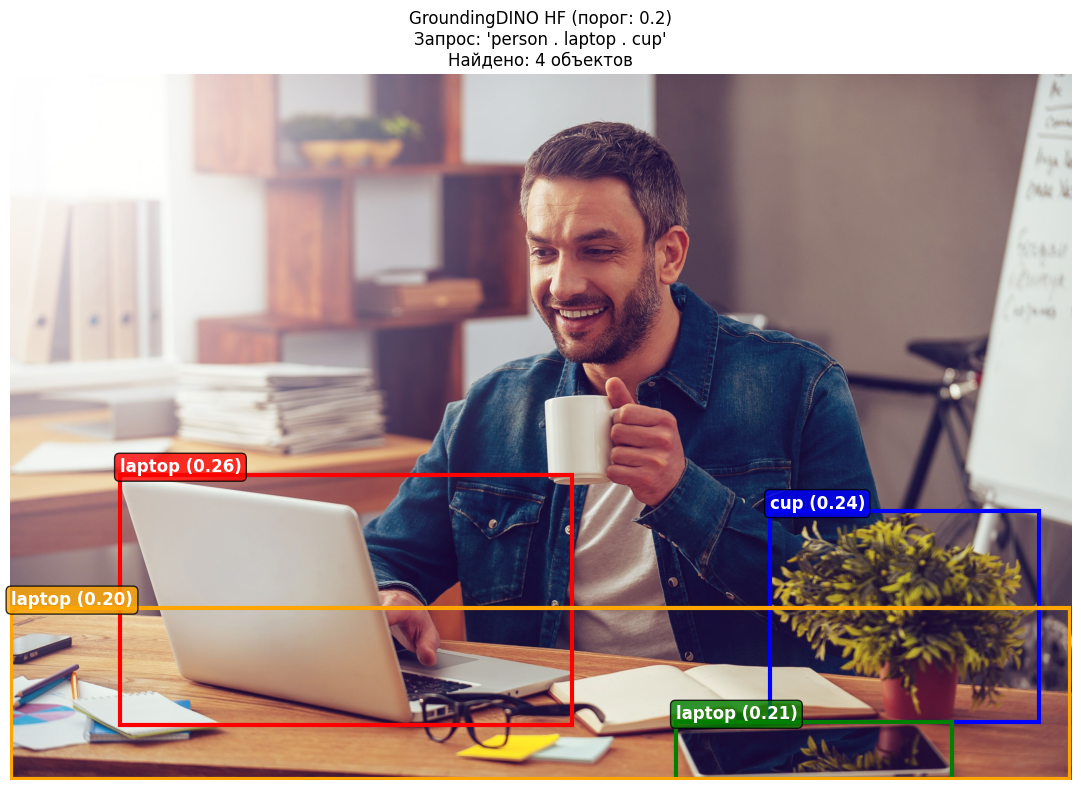


=== ТЕСТ С ПОРОГОМ 0.7 ===
📥 Загружаем модель из Hugging Face...


Device set to use cuda:0


✅ Найдено после фильтрации: 0 объектов
📊 Порог уверенности: 0.3


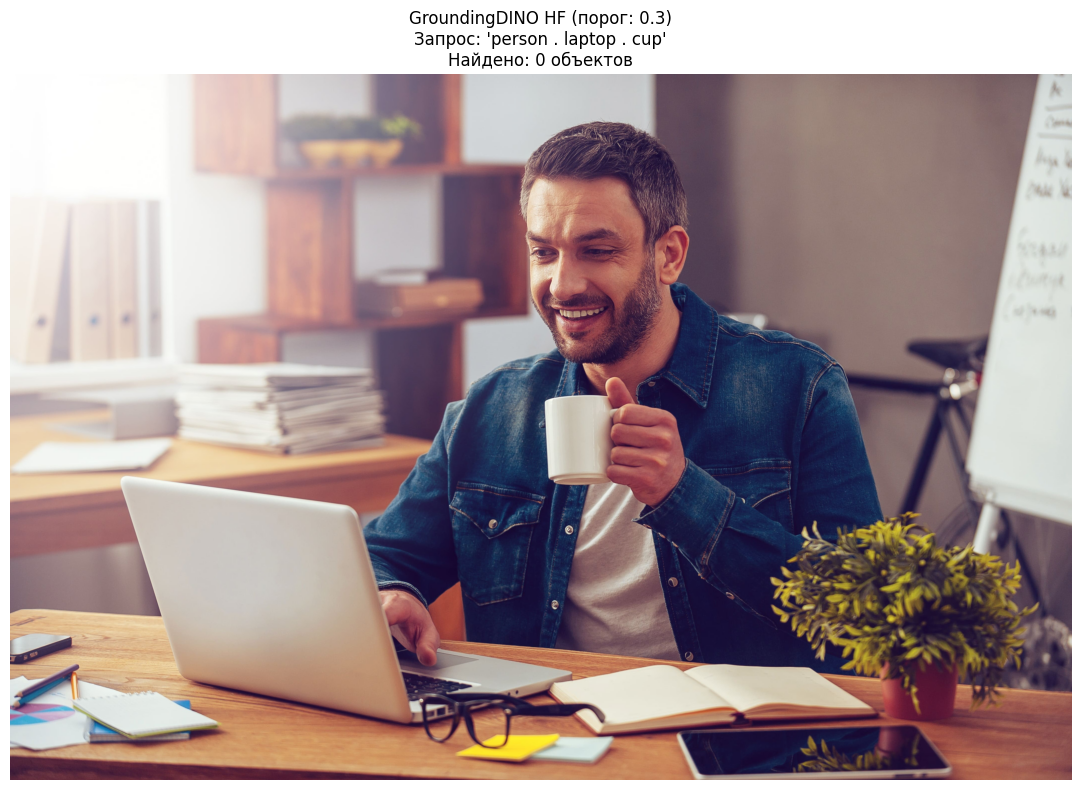

In [36]:
from transformers import pipeline
from PIL import Image
import matplotlib.pyplot as plt
import torch

def use_grounding_dino_hf_improved(image_path, text_prompt, confidence_threshold=0.5):
    """Улучшенная версия с фильтрацией по уверенности"""
    
    print("📥 Загружаем модель из Hugging Face...")
    
    try:
        # Используем ОФИЦИАЛЬНУЮ модель из HF Hub
        detector = pipeline(
            "zero-shot-object-detection", 
            model="IDEA-Research/grounding-dino-base",
            device=0 if torch.cuda.is_available() else -1
        )
        
        image = Image.open(image_path).convert("RGB")
        objects = [obj.strip() for obj in text_prompt.split('.') if obj.strip()]
        
        all_results = []
        for obj in objects:
            results = detector(image, candidate_labels=[obj])
            # Фильтруем по порогу уверенности
            filtered_results = [r for r in results if r['score'] >= confidence_threshold]
            all_results.extend(filtered_results)
        
        # Сортируем по уверенности (самые уверенные первые)
        all_results.sort(key=lambda x: x['score'], reverse=True)
        
        # Визуализация
        plt.figure(figsize=(12, 8))
        plt.imshow(image)
        
        print(f"✅ Найдено после фильтрации: {len(all_results)} объектов")
        print(f"📊 Порог уверенности: {confidence_threshold}")
        
        colors = ['red', 'blue', 'green', 'orange', 'purple']
        
        for i, result in enumerate(all_results):
            box = result['box']
            label = result['label']
            score = result['score']
            
            print(f"   {i+1}. {label} ({score:.3f})")
            
            color = colors[i % len(colors)]
            
            rect = plt.Rectangle(
                (box['xmin'], box['ymin']), 
                box['xmax']-box['xmin'], 
                box['ymax']-box['ymin'],
                linewidth=3, edgecolor=color, facecolor='none'
            )
            plt.gca().add_patch(rect)
            
            plt.text(box['xmin'], box['ymin']-10, f"{label} ({score:.2f})",
                    fontsize=12, fontweight='bold', color='white',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor=color, alpha=0.8))
        
        plt.axis('off')
        plt.title(f"GroundingDINO HF (порог: {confidence_threshold})\nЗапрос: '{text_prompt}'\nНайдено: {len(all_results)} объектов")
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"❌ Ошибка: {e}")

# 🚀 ЗАПУСК С РАЗНЫМИ ПОРОГАМИ
IMAGE_PATH = "/home/oleg/projects/ML/CLIP/images/0d354ad89e92986b19b10a8ac2797dfb.jpg"
TEXT_PROMPT = "person . laptop . cup"

print("=== ТЕСТ С ПОРОГОМ 0.5 ===")
use_grounding_dino_hf_improved(IMAGE_PATH, TEXT_PROMPT, confidence_threshold=0.2)

print("\n=== ТЕСТ С ПОРОГОМ 0.7 ===")
use_grounding_dino_hf_improved(IMAGE_PATH, TEXT_PROMPT, confidence_threshold=0.3)